In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from LinearRegDiagnostic2 import LinearRegDiagnostic2

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']= 12
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
df = pd.read_excel('/home/joao/Documents/RegressionPetro/data/rawdata_vp_poro.xlsx')

In [3]:
df.head()

,sample,formation,lithology,lithofacies,vp,porosity,density,reference
0,SG-79E-3,Torres,Basalt,Lower Crust,4.799273,6.083408,2.573227,Rossetti et al. (2019)
1,SG-79E-1,Torres,Basalt,Lower Crust,4.316942,7.667464,2.471437,Rossetti et al. (2019)
2,SG-79E-2,Torres,Basalt,Lower Crust,3.964627,7.219076,2.447632,Rossetti et al. (2019)
3,SG-80A-1,Torres,Basalt,Lower Crust,4.182352,5.566899,2.602406,Rossetti et al. (2019)
4,SG-80A-2,Torres,Basalt,Lower Crust,4.128584,7.447569,2.526487,Rossetti et al. (2019)


In [4]:
df.describe()

,vp,porosity,density
count,159.000000,159.000000,159.000000
mean,4.984539,4.723975,2.620548
std,0.730401,5.076311,0.213205
min,3.062088,0.300000,2.085680
25%,4.473758,1.241741,2.492927
50%,5.088973,2.495703,2.657042
75%,5.548061,6.246826,2.786847
max,6.240000,22.344808,2.958411


### Domain-driven feature engineering  
* **Log-transform porosity** – makes the variance roughly constant (Poisson-like counts become Gaussian in log-space).  
* **Center vp before squaring** – keeps the linear and quadratic terms nearly orthogonal, dramatically reducing multicollinearity and the variance of β-estimates.  
Both choices are supported by prior empirical work on basalt acoustic properties and improve model stability.

*This data was already cleaned for missing values, spelling errors, and outliers previously.

In [5]:
df['log_poro'] = np.log10(df['porosity'])

In [6]:
df['vp_centered'] = df['vp'] - np.mean(df['vp'])

In [7]:
df.head()

,sample,formation,lithology,lithofacies,vp,porosity,density,reference,log_poro,vp_centered
0,SG-79E-3,Torres,Basalt,Lower Crust,4.799273,6.083408,2.573227,Rossetti et al. (2019),0.784147,-0.185266
1,SG-79E-1,Torres,Basalt,Lower Crust,4.316942,7.667464,2.471437,Rossetti et al. (2019),0.884652,-0.667597
2,SG-79E-2,Torres,Basalt,Lower Crust,3.964627,7.219076,2.447632,Rossetti et al. (2019),0.858482,-1.019912
3,SG-80A-1,Torres,Basalt,Lower Crust,4.182352,5.566899,2.602406,Rossetti et al. (2019),0.745613,-0.802188
4,SG-80A-2,Torres,Basalt,Lower Crust,4.128584,7.447569,2.526487,Rossetti et al. (2019),0.872015,-0.855955


### Selecting the optimal polynomial degree  
We compare 1-10 degree polynomials using:  

| Metric | What it measures | Desired direction |
|--------|------------------|-------------------|
| **AIC** | In-sample fit penalised by parameter count | ↓ minimum |
| **BIC** | Stricter penalty for extra parameters | ↓ minimum |
| **CV-MSE** | 5-fold out-of-sample error | ↓ minimum |

All three metrics agree on **degree = 2** (quadratic) – the “elbow” where extra complexity stops paying off.


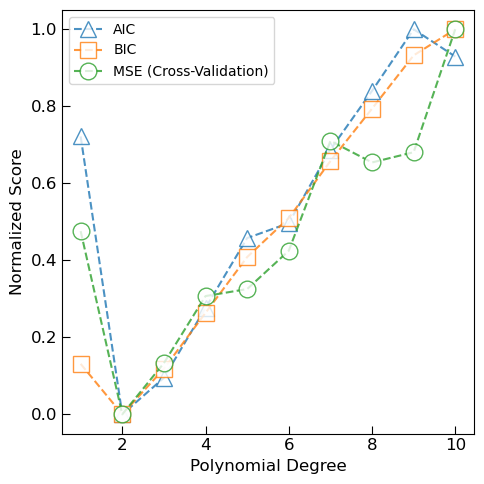

In [8]:
x = df['vp_centered']
y = df['log_poro']
aic_values = []
bic_values = []
mse_values = []
max_degree = 10
k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=1)

for deg in range(1, max_degree+1):
    x_poly = x.copy()
    x_poly = sm.add_constant(x_poly)
    
    for i in range(2, deg+1):
        x_poly[f'vp_{i}'] = x_poly['vp_centered'] ** i
    
    model_poly = sm.OLS(y, x_poly).fit()
    robust_model_poly = model_poly.get_robustcov_results()
    
    aic_values.append(robust_model_poly.aic)
    bic_values.append(robust_model_poly.bic)
    
    mse_cv = []
    for train_index, test_index in kf.split(x_poly):
        X_train, X_test = x_poly.iloc[train_index], x_poly.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model_cv = sm.OLS(y_train, X_train).fit()
        y_pred = model_cv.predict(X_test)
        mse_cv.append(mean_squared_error(y_test, y_pred))
    
    mse_values.append(np.mean(mse_cv))

scaler = MinMaxScaler()
aic_values_scaled = scaler.fit_transform(np.array(aic_values).reshape(-1, 1))
bic_values_scaled = scaler.fit_transform(np.array(bic_values).reshape(-1, 1))
mse_values_scaled = scaler.fit_transform(np.array(mse_values).reshape(-1, 1))

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(range(1, max_degree+1), aic_values_scaled, marker='^', mfc='w', markersize=12, linestyle='--', label='AIC', alpha=0.8)
ax.plot(range(1, max_degree+1), bic_values_scaled, marker='s', mfc='w', markersize=12, linestyle='--', label='BIC', alpha=0.8)
ax.plot(range(1, max_degree+1), mse_values_scaled, marker='o', mfc='w', markersize=12, linestyle='--', label='MSE (Cross-Validation)', alpha=0.8)

ax.tick_params(which='major', direction='in', size=6, labelsize=12)

ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Normalized Score')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

### Final quadratic model  

The centred quadratic explains **81.6 % (R²) / 81.4 % (Adj. R²)** of the variance in log-porosity.  
All coefficients are highly significant (*p* < 0.001) and the heteroskedasticity-robust standard errors confirm stability.

$$
\log_{10}\!\bigl(\text{porosity}\bigr)
      \;=\; 0.4912
      \;-\; 0.5858\,x
      \;-\; 0.0770\,x^{2},
$$

where \(x\) is vp centred at its mean (≈ 4.06 km s⁻¹).

In [9]:
x = df['vp_centered']
y = df['log_poro']
x = sm.add_constant(x) 
x['vp_squared'] = x['vp_centered'] ** 2 

model_quad = sm.OLS(y, x).fit()
robust_model_quad = model_quad.get_robustcov_results()

predictions = robust_model_quad.predict(x)

print_model_quad = robust_model_quad.summary()
print(print_model_quad)

                            OLS Regression Results                            
Dep. Variable:               log_poro   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     655.6
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.20e-76
Time:                        17:19:38   Log-Likelihood:                 38.169
No. Observations:                 159   AIC:                            -70.34
Df Residuals:                     156   BIC:                            -61.13
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4912      0.022     22.360      

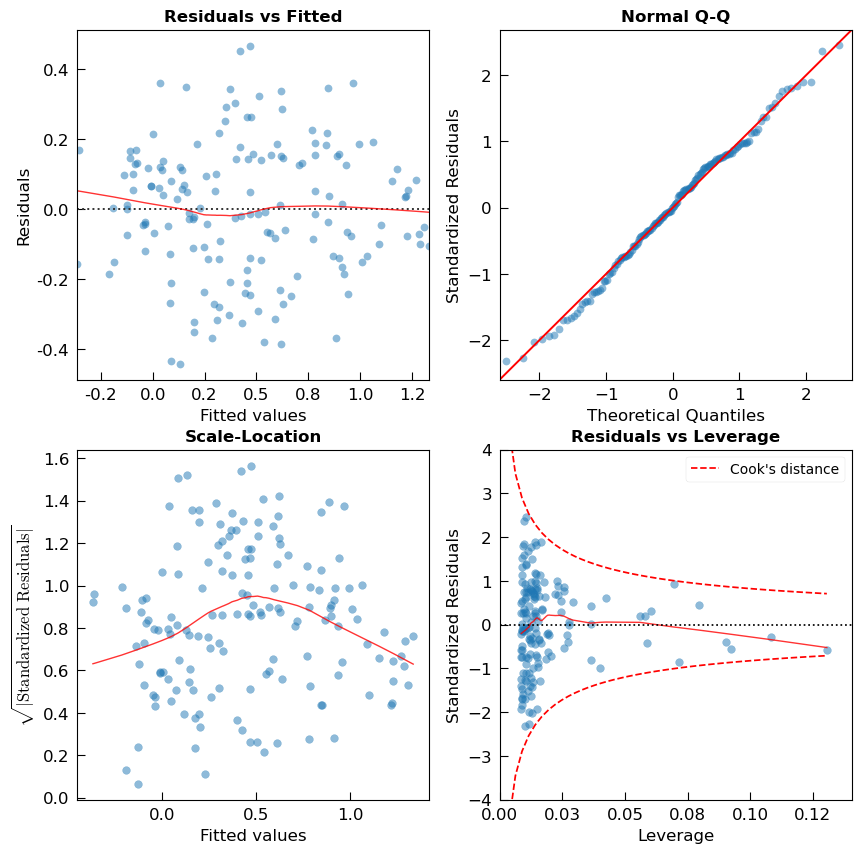

      Features  VIF Factor
1  vp_centered        1.35
2   vp_squared        1.35
0        const        1.74


In [10]:
cls = LinearRegDiagnostic2(model_quad)
vif, fig, ax = cls(plot_context='seaborn-v0_8-paper', cooks_threshold='convention')
print(vif)

### VIF diagnostics – multicollinearity check

**What VIF means**  
* The Variance Inflation Factor quantifies how much the variance of a coefficient is inflated by linear correlations with the other features.  
* A rule-of-thumb scale:  
  * **≈ 1.0** : no multicollinearity  
  * **1–5** : generally harmless  
  * **> 10** : serious concern  

**Interpretation for this model**  
* Both engineered predictors sit at **1.35**, well inside the safe zone – evidence that centering vp before squaring successfully reduced correlation between the linear and quadratic terms.  
* The intercept’s VIF (1.74) is also modest, confirming the model is numerically stable and coefficient estimates should have tight confidence intervals.

### Regression diagnostics  
* **Residuals vs Fitted** – no funnel shape : homoscedasticity assumption reasonable.  
* **Normal Q-Q** – points fall on 45° line : residuals ~ N(0, σ²).  
* **Scale-Location** – slight uptick then downtrend, but within ±1.6 √|resid|; acceptable.  
* **Cook’s distance** – all leverage points lie inside the standard 0.5 contour; no influential outliers.  

Conclusion: assumptions hold; no immediate red flags.

In [11]:
intervals = robust_model_quad.get_prediction(x)

In [12]:
intervals.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.597085,0.023266,0.551128,0.643041,0.214757,0.979412
1,0.847966,0.023111,0.802314,0.893618,0.465675,1.230257
2,1.008590,0.020804,0.967495,1.049685,0.626816,1.390364
3,0.911582,0.022282,0.867569,0.955595,0.529483,1.293681
4,0.936217,0.021906,0.892947,0.979487,0.554203,1.318231
...,...,...,...,...,...,...
154,-0.212794,0.030066,-0.272183,-0.153406,-0.596968,0.171379
155,-0.365518,0.040238,-0.445001,-0.286036,-0.753307,0.022270
156,0.081043,0.018454,0.044591,0.117495,-0.300259,0.462345
157,-0.190417,0.028757,-0.247220,-0.133613,-0.574199,0.193366


In [13]:
s_ci_lower, s_ci_upper = intervals.conf_int().T

In [14]:
predictions_intervals = intervals.summary_frame(alpha=0.05)

In [15]:
s_pi_lower = predictions_intervals['obs_ci_lower']
s_pi_upper = predictions_intervals['obs_ci_upper']

In [16]:
df2 = pd.DataFrame()
df2['vp_centered'] = df['vp_centered']
df2['predictions'] = predictions
df2['confidence_lower'] = s_ci_lower
df2['confidence_upper'] = s_ci_upper
df2['prediction_lower'] = s_pi_lower
df2['prediction_upper'] = s_pi_upper

In [17]:
df2.sort_values(by=['vp_centered'], inplace=True)

In [18]:
df2.head()

,vp_centered,predictions,confidence_lower,confidence_upper,prediction_lower,prediction_upper
138,-1.922451,1.332909,1.254601,1.411216,0.945359,1.720458
91,-1.838597,1.308060,1.237994,1.378125,0.922091,1.694028
46,-1.770570,1.287105,1.223091,1.351120,0.902190,1.672021
100,-1.761530,1.284267,1.221011,1.347523,0.899477,1.669058
96,-1.707806,1.267141,1.208167,1.326115,0.883031,1.651251


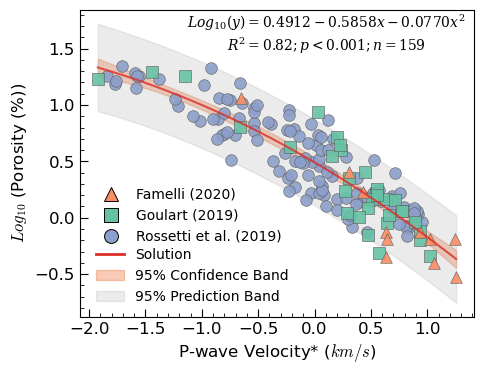

In [ ]:
colors = {'Famelli (2020)':'#fc8d62', 'Goulart (2019)':'#66c2a5', 'Rossetti et al. (2019)':'#8da0cb'}
markers = {'Famelli (2020)': '^', 'Goulart (2019)': 's', 'Rossetti et al. (2019)': 'o'}

fig, ax = plt.subplots(1, figsize=(5,5))

fill1 = ax.fill_between(df2['vp_centered'], df2['confidence_upper'], df2['confidence_lower'], color='#e6550d', alpha = 0.3)
fill2 = ax.fill_between(df2['vp_centered'], df2['prediction_upper'], df2['prediction_lower'], color='#bdbdbd', alpha = 0.3)

line1, = ax.plot(df2['vp_centered'], df2['predictions'], color='#de2d26', linestyle='-', alpha = 0.8)

for group in df['reference'].unique():
    df_group = df[df['reference'] == group]
    ax.scatter(df_group['vp_centered'], df_group['log_poro'], edgecolors='#636363', s = 70, linewidths = 0.5, marker=markers[group], color=colors[group], alpha=0.9)  

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.tick_params(which='minor', direction='in', size=3)
ax.tick_params(which='major', direction='in', size=6)

ax.set_xlabel('P-wave Velocity* ($km/s$)')
ax.set_ylabel('$Log_{10}$ (Porosity (%))')

scatter_legend_elements = [Line2D([0], [0], marker=markers[group], color='w', label=group, markerfacecolor=colors[group], markersize=10, markeredgewidth=0.7, markeredgecolor='black') for group in df['reference'].unique()]
scatter_legend_elements = [scatter_legend_elements[2], scatter_legend_elements[1], scatter_legend_elements[0]]

line_legend_elements = [Line2D([0], [0], color=line1.get_color(), lw=2, label='Solution'),
                        Patch(facecolor=fill1.get_facecolor()[0], edgecolor=fill1.get_edgecolor(), alpha=0.3, label='95% Confidence Band'),
                        Patch(facecolor=fill2.get_facecolor()[0], edgecolor=fill2.get_edgecolor(), alpha=0.3, label='95% Prediction Band')]

scatter_legend = fig.legend(handles=scatter_legend_elements, loc='lower center', fontsize=10, bbox_to_anchor=(0.395, 0.32), frameon=False, ncol=1)
line_legend = fig.legend(handles=line_legend_elements, loc='lower center', fontsize=10, bbox_to_anchor=(0.4, 0.2), frameon=False, ncol=1)

fig.text(0.39, 0.73, r'$Log_{10}(y) = 0.4912 - 0.5858x - 0.0770x^2$' + '\n' +
         r'$R^2 = 0.82; p < 0.001; n = 159$', fontsize=10, 
         math_fontfamily='dejavuserif', multialignment = 'center')

ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

### Visualising fit with uncertainty  
The orange ribbon = 95 % **confidence band** (uncertainty on the mean response).  
The grey ribbon = 95 % **prediction band** (uncertainty on *individual* future observations).  
Note how the prediction band widens as vp deviates from the mean – a cue to avoid extrapolating beyond the sampled velocity range.

### Why examine RSS contour maps?  

Residual-sum-of-squares (RSS) contour plots visualise the **shape of the loss surface** in coefficient space.  
They reveal:

1. **Convexity** – Convex, elliptical contours indicate the optimisation landscape has a single global minimum, so ordinary least-squares can’t get “stuck” in local minima.  
2. **Correlation between parameters** – The orientation (tilt) of the ellipses shows how strongly pairs of coefficients trade off against each other. A steeper tilt means higher negative correlation and wider confidence intervals.  
3. **Sensitivity** – Tight, circular contours imply small changes in β produce large RSS changes : precise estimates. Flattened ellipses mean the opposite.

In [20]:
# Beta calculations
b0_orig = robust_model_quad.params[0]
b1_orig = robust_model_quad.params[1]
b2_orig = robust_model_quad.params[2]

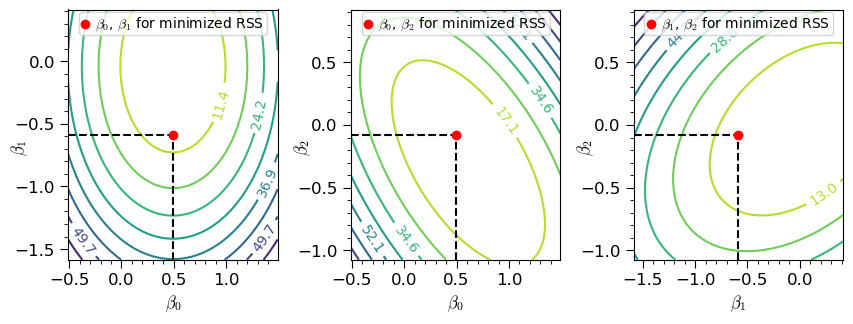

In [21]:
fig = plt.figure(figsize=(10, 3.25))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.35)
 
for idx, (b1, b2, label1, label2) in enumerate([(b0_orig, b1_orig, r'$\beta_0$', r'$\beta_1$'), 
                                                (b0_orig, b2_orig, r'$\beta_0$', r'$\beta_2$'), 
                                                (b1_orig, b2_orig, r'$\beta_1$', r'$\beta_2$')]):
    B1 = np.linspace(b1-1, b1+1, 100)
    B2 = np.linspace(b2-1, b2+1, 100)
    xx, yy = np.meshgrid(B1, B2, indexing='xy')
    Z = np.zeros((B1.size, B2.size))
    
    for (i, j), v in np.ndenumerate(Z):
        if idx == 0:
            params = np.array([xx[i,j], yy[i,j], b2_orig])
        elif idx == 1:
            params = np.array([xx[i,j], b1_orig, yy[i,j]])
        else:
            params = np.array([b0_orig, xx[i,j], yy[i,j]])
        
        X = np.column_stack((np.ones(len(x['vp_centered'])), x['vp_centered'], x['vp_centered']**2))
        Z[i,j] = np.sum((y.values.reshape(-1,1) - np.dot(X, params)) ** 2) / 1000
    
    ax = fig.add_subplot(gs[0, idx])
    
    CS = ax.contour(xx, yy, Z, cmap='viridis_r', levels=np.linspace(Z.min(), Z.max(), 10))
    
    levels = np.append(CS.levels[0], CS.levels[1::2])

    ax.clabel(CS, inline=True, fontsize=10, fmt='%1.1f', levels=levels)
    
    ax.plot([np.min(B1), b1], [b2, b2], color='black', linestyle='--')
    ax.plot([b1, b1], [np.min(B2), b2], color='black', linestyle='--')
    
    ax.scatter(b1, b2, color='red', label=f'{label1}, {label2} for minimized RSS', zorder=3)
    
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='out', size=3)
    ax.tick_params(which='major', direction='out', size=6)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    
    ax.yaxis.set_label_coords(-0.18,0.45)
    
    ax.legend(fontsize=10, handlelength=0.5, handletextpad=0.5, borderaxespad=0.2, loc='upper center', borderpad=0.2)

plt.tight_layout()
plt.show()

### Interpreting the RSS contour maps  

* **β₀ vs β₁** – Ellipse is nearly upright thanks to centering; intercept and linear term are weakly correlated, improving interpretability.  
* **β₀ vs β₂** – Slight tilt shows the intercept and quadratic term share modest correlation; confidence intervals remain tight given the small semi-minor axis.  
* **β₁ vs β₂** – Ellipse tilts noticeably, confirming the linear and quadratic terms interact (expected, as both are powers of vp). However, the contours are still well-spaced and convex, signalling a well-posed estimation problem with a clear minimum.  

Overall, the maps corroborate the VIF results: **no problematic multicollinearity** and a single, well-defined global RSS minimum.

### Key take-aways  
* Quadratic relationship captures 82 % of porosity variance across three independent basalt datasets.  
* Model satisfies linearity, normality, and homoscedasticity diagnostics.  
* Approach balances **parsimony** (BIC) with **predictive skill** (CV-MSE), showcasing disciplined model selection.  